## **Connection between hana Database and Python**


In [ ]:
pip install hana_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 75.5 MB/s eta 0:00:00


In [ ]:

pip install hdbcli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hdbcli import dbapi

In [ ]:
import json
sap_hana_config_file = "parameter.json"
with open(sap_hana_config_file) as f:
    sap_hana_config = json.load(f)
    db_url  = sap_hana_config['url']
    db_port = sap_hana_config['port']
    db_user = sap_hana_config['user']
    db_pwd  = sap_hana_config['pwd']

In [ ]:
from hana_ml.dataframe import ConnectionContext
cc = ConnectionContext(db_url, db_port, db_user, db_pwd)
cc

In [ ]:
print(cc.hana_version())

4.00.000.00.1673356761 (fa/CE2022.42)


In [ ]:
hana_ml_df = cc.table('MACHINE_FAILURE', schema='DBADMIN')
hana_ml_df

## **Explore and pre process the data**

In [ ]:
df = hana_ml_df.collect()

In [ ]:
describe = df.describe()
type(describe)

pandas.core.frame.DataFrame

In [ ]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,299.552200,309.552000,1538.776100,39.533400,107.951000,0.033900
std,2.014071,1.511597,179.284096,9.975662,63.654147,0.180981
min,295.000000,305.000000,1168.000000,3.000000,0.000000,0.000000
25%,298.000000,308.000000,1423.000000,33.000000,53.000000,0.000000
50%,300.000000,310.000000,1503.000000,40.000000,108.000000,0.000000
75%,301.000000,311.000000,1612.000000,46.000000,162.000000,0.000000
max,304.000000,313.000000,2886.000000,76.000000,253.000000,1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve,f1_score, precision_score, recall_score #scorer,
from matplotlib import pyplot
import pandas as pd

In [ ]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
dtype: int64

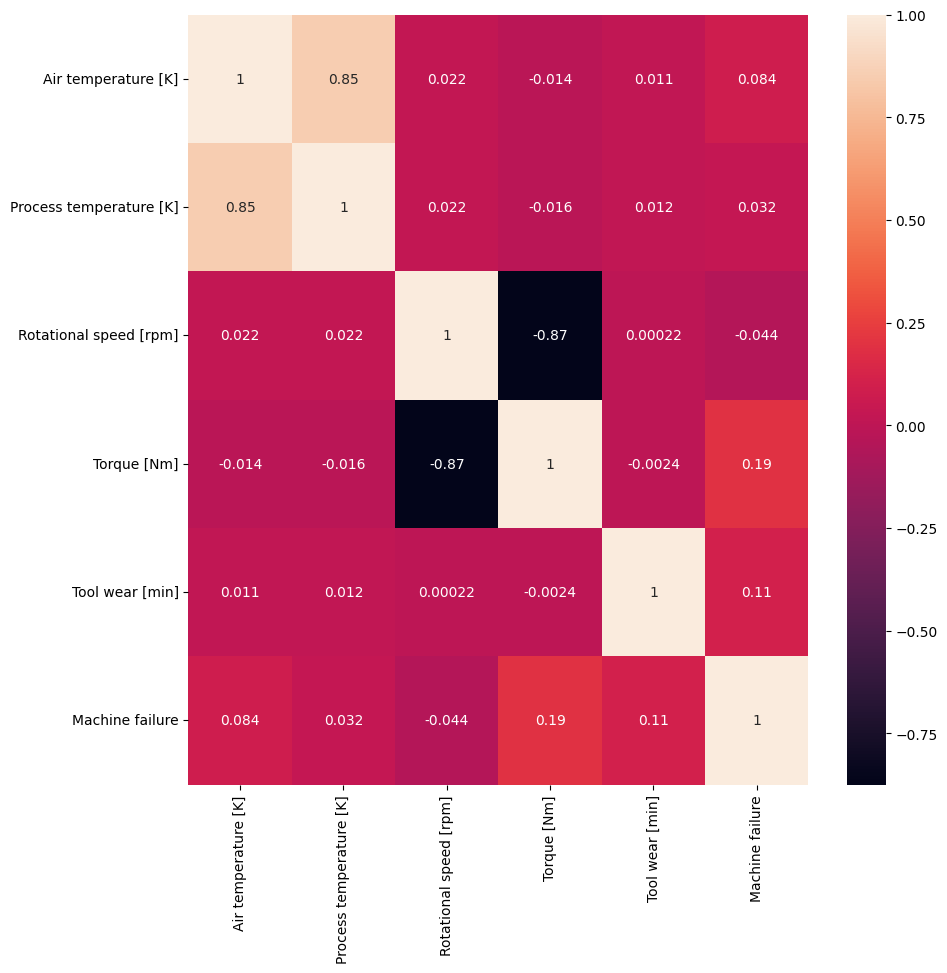

In [ ]:
corr = df.corr()
plt.figure (figsize = (10,10))
sns.heatmap(corr,annot=True)
plt.show()

<Axes: xlabel='Machine failure', ylabel='count'>

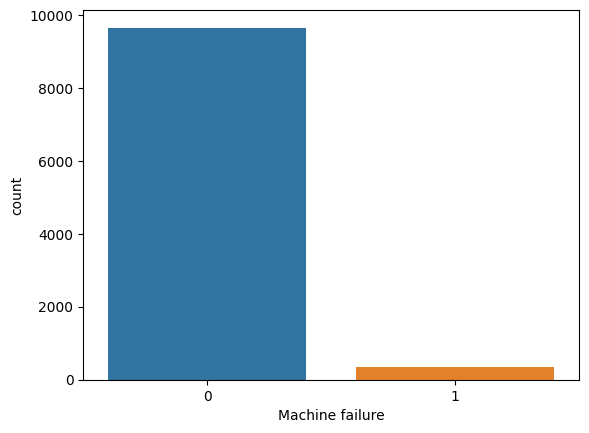

In [ ]:
sns.countplot(x='Machine failure', data=df)

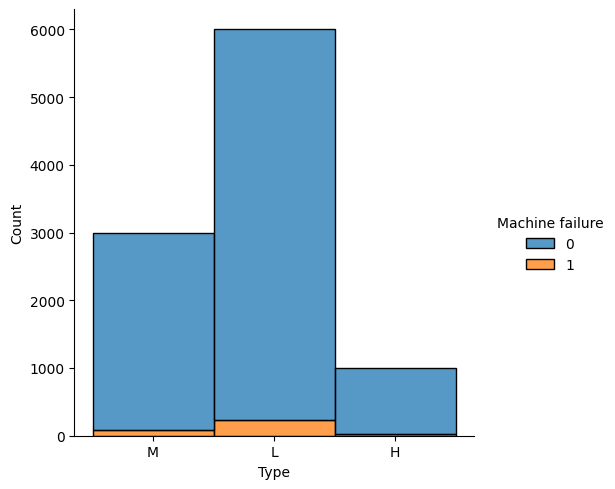

In [ ]:
sns.displot(df,x='Type',hue='Machine failure', multiple="stack")

In [ ]:
df['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [ ]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           10
Process temperature [K]        9
Rotational speed [rpm]       941
Torque [Nm]                   72
Tool wear [min]              246
Machine failure                2
dtype: int64

In [ ]:
df["Type"].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [ ]:
y=df['Machine failure']
x=df.drop(['Machine failure','Product ID','Type'],axis=1)
x.head()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,298,308,1551,42,0
1,2,298,308,1408,46,3
2,3,298,308,1498,49,5
3,4,298,308,1433,39,7
4,5,298,308,1408,40,9


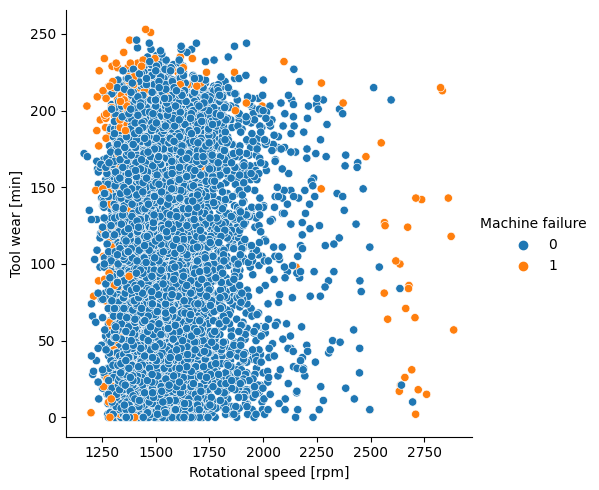

In [ ]:
sns.relplot(y='Tool wear [min]',x='Rotational speed [rpm]',hue="Machine failure", data=df)

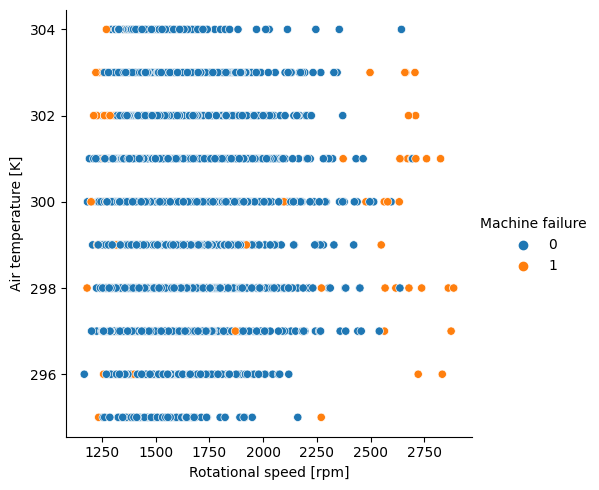

In [ ]:
sns.relplot(y='Air temperature [K]',x='Rotational speed [rpm]',hue="Machine failure", data=df)

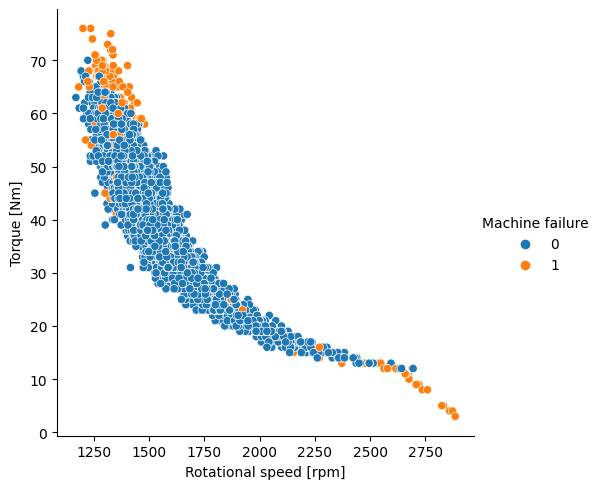

In [ ]:
sns.relplot(y='Torque [Nm]',x='Rotational speed [rpm]',hue="Machine failure", data = df)

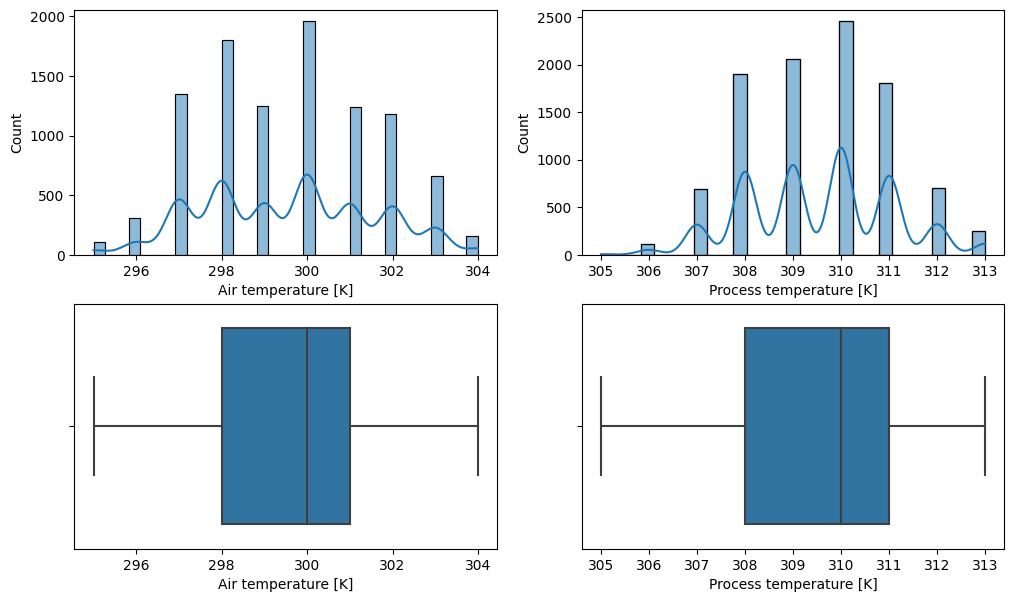

In [ ]:
fig, ax =plt.subplots(2, 2, figsize=(12,7))
sns.histplot(data=df, x ='Air temperature [K]', kde=True, ax=ax[0,0])
sns.histplot(data=df, x ='Process temperature [K]', kde=True, ax=ax[0,1])
sns.boxplot(data=df, x ='Air temperature [K]', ax=ax[1,0])
sns.boxplot(data=df, x ='Process temperature [K]', ax=ax[1,1])
plt.show()

In [ ]:
from hana_ml import dataframe
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification
from hana_ml.visualizers.unified_report import UnifiedReport

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.3)
x_train.head()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
2228,2229,299,308,1542,41,166
5910,6788,301,310,1388,58,68
1950,1951,298,307,1479,47,76
2119,2120,299,308,1858,24,101
5947,6825,300,310,1740,25,164


In [ ]:

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

train_minmax = minmax.fit_transform(x)

X = pd.DataFrame(train_minmax, columns=x_train.columns)

In [ ]:
X

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.000000,0.333333,0.375,0.222934,0.534247,0.000000
1,0.000100,0.333333,0.375,0.139697,0.589041,0.011858
2,0.000200,0.333333,0.375,0.192084,0.630137,0.019763
3,0.000300,0.333333,0.375,0.154249,0.493151,0.027668
4,0.000400,0.333333,0.375,0.139697,0.506849,0.035573
...,...,...,...,...,...,...
9995,0.989799,0.333333,0.500,0.110012,0.602740,0.695652
9996,0.989899,0.333333,0.500,0.132712,0.561644,0.703557
9997,0.989999,0.333333,0.500,0.243306,0.383562,0.711462
9998,0.990099,0.333333,0.500,0.163562,0.534247,0.719368


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.3)

# **Train and test the accuracy**

## Random Forest Classification

In [ ]:
X_train = X_train.drop(['UDI'], axis = 1)
X_test = X_test.drop(['UDI'], axis = 1)

0.982
Area under curve: 0.7914031343331286 



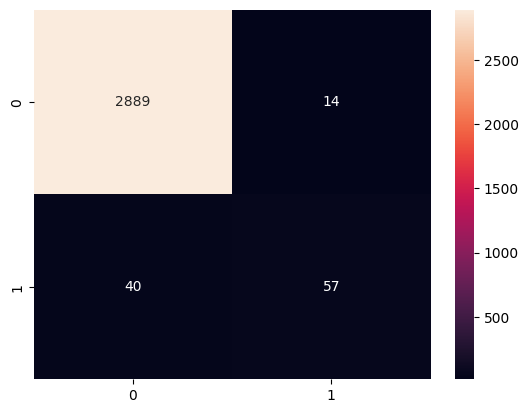

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

predictions=rfc.predict(X_test)
accscore=accuracy_score(y_test,predictions)
print(accscore)
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt='g')
#roc_auc_score
model_roc_auc = roc_auc_score(y_test, predictions) 
print("Area under curve:", model_roc_auc,"\n")

In [ ]:
tst = df[df['Machine failure']==0]

tst = tst.drop(['Product ID','Type','Machine failure','UDI'], axis = 1)
tst = tst[:4]
tst

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298,308,1551,42,0
1,298,308,1408,46,3
2,298,308,1498,49,5
3,298,308,1433,39,7


In [ ]:
pred = rfc.predict(tst)
pred

array([1, 1, 1, 1])

In [ ]:
import pickle

filename = "rfc.pkl"
pickle.dump(rfc, open(filename, "wb"))

import joblib
joblib.dump(rfc, "my_random_forest.joblib")

['my_random_forest.joblib']

In [ ]:
X_test.dtypes
X_test.to_csv('test.csv',index=False)
X_test

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
9953,0.333333,0.500,0.202561,0.479452,0.241107
3850,0.777778,0.875,0.200815,0.465753,0.363636
4962,0.777778,0.625,0.391735,0.273973,0.470356
3886,0.777778,0.875,0.146682,0.657534,0.719368
5437,0.777778,0.625,0.249709,0.520548,0.059289
...,...,...,...,...,...
5273,0.777778,0.625,0.125146,0.534247,0.094862
8014,0.888889,1.000,0.206636,0.493151,0.592885
8984,0.555556,0.875,0.559371,0.191781,0.683794
6498,0.444444,0.625,0.231083,0.452055,0.501976


In [ ]:
test = pd.read_csv('test.csv')
test

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.333333,0.500,0.202561,0.479452,0.241107
1,0.777778,0.875,0.200815,0.465753,0.363636
2,0.777778,0.625,0.391735,0.273973,0.470356
3,0.777778,0.875,0.146682,0.657534,0.719368
4,0.777778,0.625,0.249709,0.520548,0.059289
...,...,...,...,...,...
2995,0.777778,0.625,0.125146,0.534247,0.094862
2996,0.888889,1.000,0.206636,0.493151,0.592885
2997,0.555556,0.875,0.559371,0.191781,0.683794
2998,0.444444,0.625,0.231083,0.452055,0.501976


In [ ]:
x_test.head()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
9953,9856,298,309,1516,38,61
3850,5605,302,312,1513,37,92
4962,4086,302,310,1841,23,119
3886,5641,302,312,1420,51,182
5437,4561,302,310,1597,41,15


In [ ]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

## Logistic Regression

0.9686666666666667
Area under curve: 0.5154639175257731 



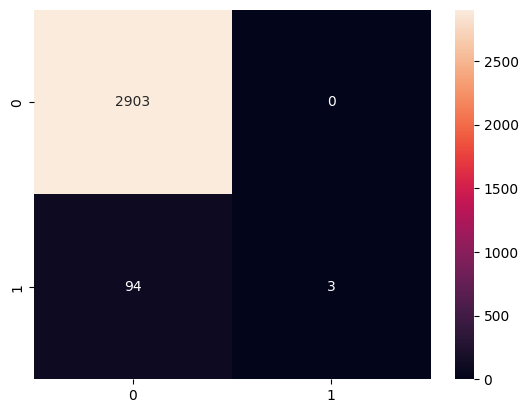

In [ ]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_train, y_train)
predictions=lr.predict(X_test)
accscore=accuracy_score(y_test,predictions)
print(accscore)
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm,annot=True,fmt='g')
#roc_auc_score
model_roc_auc = roc_auc_score(y_test, predictions) 
print("Area under curve:", model_roc_auc,"\n")

In [ ]:
filename = "lr.pickle"
pickle.dump(lr, open(filename, "wb"))

In [ ]:
pred = rfc.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
X_test.to_csv('test.csv')


In [ ]:
X_2 = x
X_2['flag'] = y
X_2

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],flag
0,1,298,308,1551,42,0,0
1,2,298,308,1408,46,3,0
2,3,298,308,1498,49,5,0
3,4,298,308,1433,39,7,0
4,5,298,308,1408,40,9,0
...,...,...,...,...,...,...,...
9995,9898,298,309,1357,47,176,0
9996,9899,298,309,1396,44,178,0
9997,9900,298,309,1586,31,180,0
9998,9901,298,309,1449,42,182,0


In [ ]:
X_0 = X_2[X_2['flag']==0]
X_1 = X_2[X_2['flag']==1]

X_final = X_0[:20]
X_final = X_final.append(X_1[:20])
X_final.shape

<ipython-input-57-e55542f8cff0>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_final = X_final.append(X_1[:20])


(40, 7)

In [ ]:
X_final = X_final.drop(['UDI','flag'], axis = 1)
X_final.to_csv('test.csv',index=False)

In [ ]:
cc.sql_tracer.enable_sql_trace(True)
cc.sql_tracer.enable_trace_history(True)

In [ ]:
import hana_ml

generator = hana_ml.artifacts.generators.abap.AMDPGenerator(project_name="PIMA_DIAB", version="1", connection_context=cc, outputdir="out/")
generator.generate()

ValueError: ignored

In [ ]:
df = df.drop('UDI',axis = 1)

In [ ]:
df_test = df.drop(['Product ID'],axis = 1)
df_test

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298,308,1551,42,0,0
1,L,298,308,1408,46,3,0
2,L,298,308,1498,49,5,0
3,L,298,308,1433,39,7,0
4,L,298,308,1408,40,9,0
...,...,...,...,...,...,...,...
9995,L,298,309,1357,47,176,0
9996,L,298,309,1396,44,178,0
9997,L,298,309,1586,31,180,0
9998,H,298,309,1449,42,182,0


In [ ]:
from joblib.parallel import cpu_count
cc.sql_tracer.enable_sql_trace(True)
cc.sql_tracer.enable_trace_history(True)
rfc_params = dict(n_estimators=5, split_threshold=0, max_depth=10)
rfc = UnifiedClassification(func="randomdecisiontree", **rfc_params)
rfc.fit(hana_ml_df,
            key='UDI',
            label='Machine Failure',
            categorical_variable=['Type','Machine Failure'],
            partition_method='stratified',
            stratified_column='CLASS')


ValueError: ignored